<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

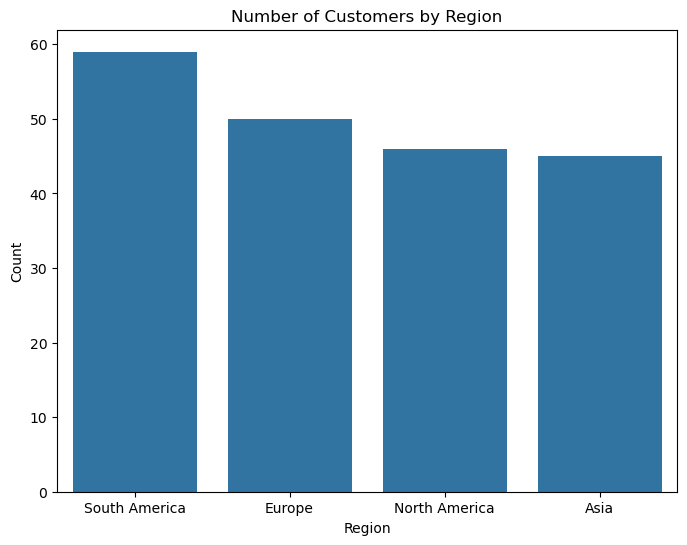

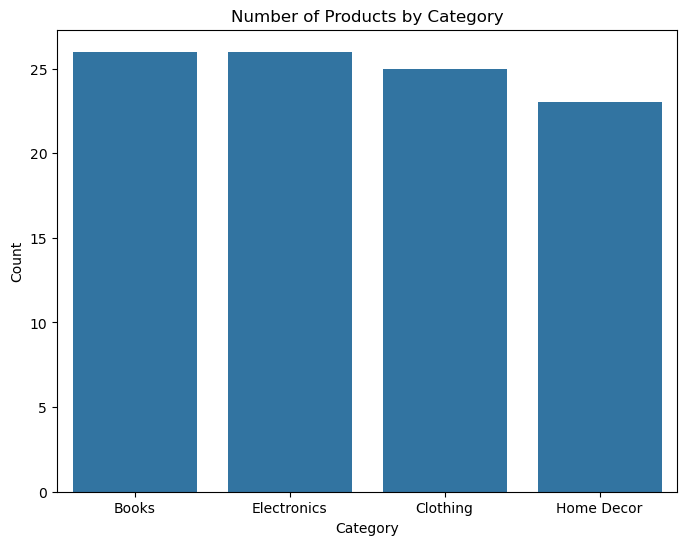

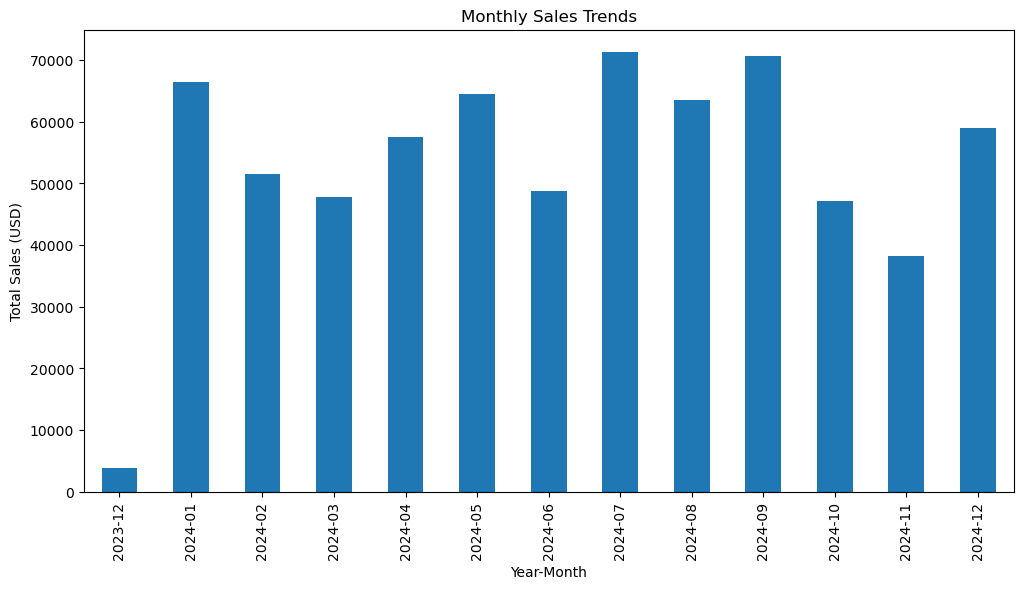

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Inspect the datasets
print(customers.info())
print(products.info())
print(transactions.info())

# Check for missing values
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())

# Analyze customer data
customer_region_count = customers['Region'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=customer_region_count.index, y=customer_region_count.values)
plt.title('Number of Customers by Region')
plt.ylabel('Count')
plt.xlabel('Region')
plt.show()

# Analyze product data
product_category_count = products['Category'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=product_category_count.index, y=product_category_count.values)
plt.title('Number of Products by Category')
plt.ylabel('Count')
plt.xlabel('Category')
plt.show()

# Analyze transaction data
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['YearMonth'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('YearMonth')['TotalValue'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar')
plt.title('Monthly Sales Trends')
plt.ylabel('Total Sales (USD)')
plt.xlabel('Year-Month')
plt.show()

# Additional EDA and insights can be derived as needed


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Merge datasets for feature creation
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Create a customer-product matrix
customer_product_matrix = data.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', fill_value=0)

# Calculate cosine similarity
similarity_matrix = cosine_similarity(customer_product_matrix)

# Find top 3 lookalikes for the first 20 customers
top_lookalikes = {}
for i, customer_id in enumerate(customer_product_matrix.index[:20]):
    similar_customers = similarity_matrix[i]
    similar_indices = np.argsort(similar_customers)[-4:-1][::-1]  # Exclude self
    top_lookalikes[customer_id] = [
        (customer_product_matrix.index[idx], similar_customers[idx]) for idx in similar_indices
    ]

# Save the lookalike results to a CSV
lookalike_df = pd.DataFrame([
    {'CustomerID': k, 'Lookalikes': v} for k, v in top_lookalikes.items()
])
lookalike_df.to_csv('FirstName_LastName_Lookalike.csv', index=False)


CustomerName        0
Region              0
SignupDate          0
TotalValue          1
Quantity            1
TransactionCount    1
dtype: int64
Davies-Bouldin Index: 0.8648494192226442


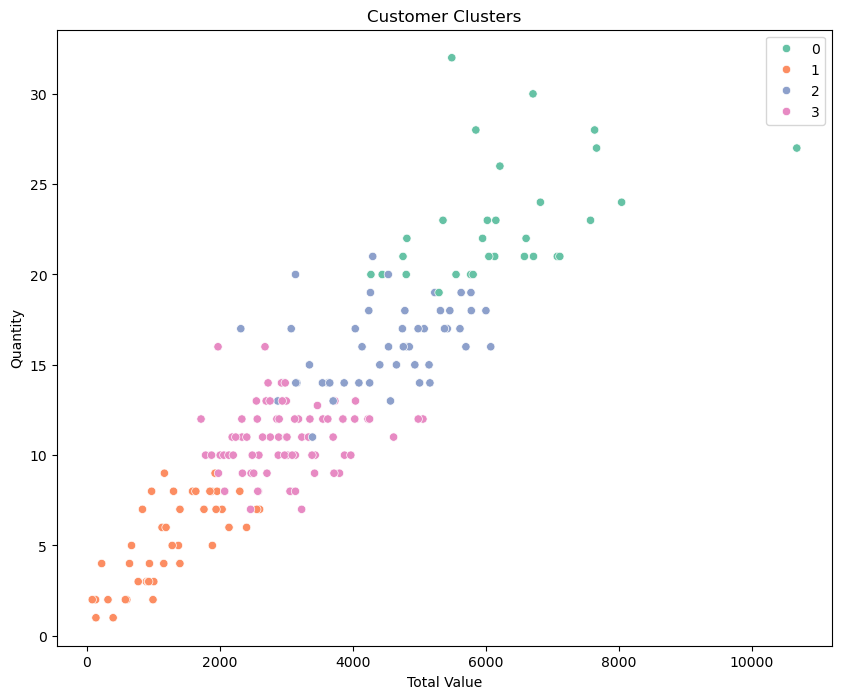

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate transaction data by customer
customer_data = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'
}).rename(columns={'TransactionID': 'TransactionCount'})

# Merge with customer profile data
customer_profile = customers.set_index('CustomerID').join(customer_data)

# Check for missing values and handle them
print(customer_profile.isnull().sum())  # Inspect missing values
imputer = SimpleImputer(strategy='mean')
features = ['TotalValue', 'Quantity', 'TransactionCount']
customer_profile[features] = imputer.fit_transform(customer_profile[features])

# Standardize the data
scaler = StandardScaler()
customer_features = scaler.fit_transform(customer_profile[features])

# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(customer_features)
customer_profile['Cluster'] = clusters

# Evaluate clustering
db_index = davies_bouldin_score(customer_features, clusters)
print(f'Davies-Bouldin Index: {db_index}')

# Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=customer_profile['TotalValue'], 
    y=customer_profile['Quantity'], 
    hue=customer_profile['Cluster'], 
    palette='Set2'
)
plt.title('Customer Clusters')
plt.xlabel('Total Value')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Save clustering results
customer_profile.to_csv('FirstName_LastName_Clustering.csv')
